<a href="https://colab.research.google.com/github/rmontteiro/ML_IGTI_bootcamp/blob/master/handsonMod4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo desse exercício é classificar imagens de flores.Utilizaremos um conjunto de imagens para ensinar à rede as novas classes que precisa reconhecer. Vamos usar um arquivo de fotos de flores licenciadas da creative-commons do Google. O conjunto de dados usado neste exemplo é distribuído como diretórios de imagens, com uma classe de imagem por diretório.

In [47]:
#Essa atividade fornece um exemplo simples de como carregar um conjunto de dados de imagens usando tf.dat
import tensorflow as tf

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [49]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [50]:
tf.__version__

'2.3.0'

Recuperando as imagens. Antes de iniciar qualquer treinamento, você precisará de um conjunto de imagens para ensinar à rede as novas aulas que deseja reconhecer. Você pode usar um arquivo de fotos de flores licenciadas da creative-commons do Google.
O conjunto de dados usado neste exemplo é distribuído como diretórios de imagens, com uma classe de imagem por diretório.


In [51]:
import pathlib
data_dir=tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos', untar=True)
data_dir= pathlib.Path(data_dir)

Após o download (218MB), você deve ter uma cópia das fotos da flor disponível.
O diretório contém 5 subdiretórios, um por classe:


In [52]:
image_count=len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [53]:
CLASS_NAMES=np.array([item.name for  item in data_dir.glob('*') if item.name !='LICENSE.txt'])
CLASS_NAMES

array(['dandelion', 'tulips', 'roses', 'daisy', 'sunflowers'],
      dtype='<U10')

Cada diretório contém imagens desse tipo de flor. Aqui estão algumas rosas:



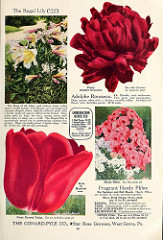

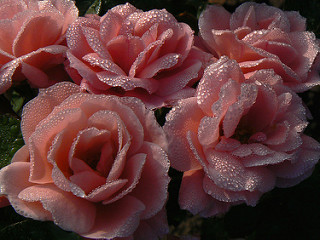

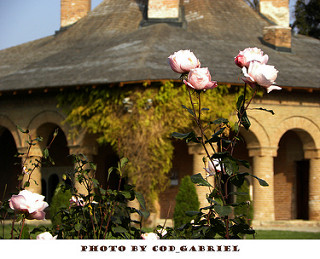

In [54]:
roses= list(data_dir.glob('roses/*'))
for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

Carregar usando keras.preprocessing
Uma maneira simples de carregar imagens é usar tf.keras.preprocessing


In [55]:
# the 1./255 is to convert from uint8 to float32 in range [0,1]
image_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [56]:
BATCH_SIZE=32
IMG_HEIGHT=224
IMG_WIDTH=224
STEPS_PER_EPOCH=np.ceil(image_count/BATCH_SIZE)

In [57]:
train_data_gen=image_generator.flow_from_directory(directory=str(data_dir),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   classes=list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


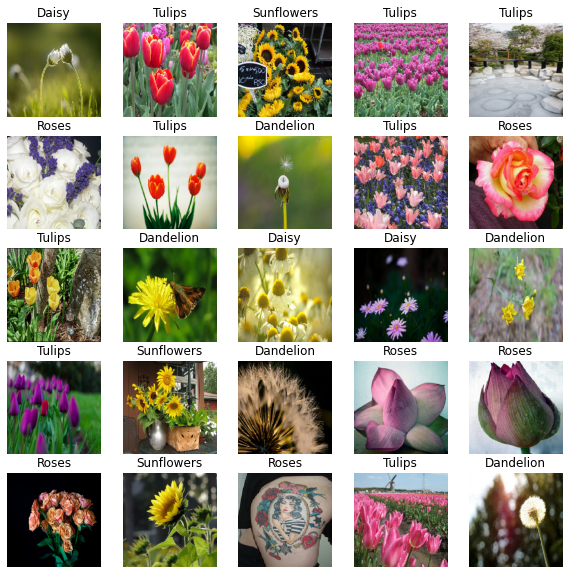

In [58]:
#INSPECIONANDO O LOTE
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax=plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch,label_batch)

Carregar usando tf.data
O método keras.preprocessing acima é conveniente, mas tem três desvantagens:
1)	É lento. Veja a seção de desempenho abaixo.
2)	Falta controle refinado.
3)	Não está bem integrado ao restante do TensorFlow.
Para carregar os arquivos como um tf.data.Dataset, primeiro crie um conjunto de dados dos caminhos do arquivo:


In [59]:
#Carregar usando tf.data
list_ds=tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/8681746439_d6beeefbf9.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/6061175433_95fdb12f32_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/2470177960_7bd67db186_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/6158504080_b844a9ae05.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/17147436650_c94ae24004_n.jpg'


Escreva uma função pure-tensorflow que converte um caminho de arquivo em um par (img, label):

In [60]:
def get_label(file_path):
  #covert the path to a list of path componentes
  parts=tf.strings.split(file_path,os.path.sep)
  #The second to last is the class-directory
  return parts[-2]==CLASS_NAMES

def decode_img(img):
  #convert the compressed string to a 3D uint8 tensor
  img=tf.image.decode_jpeg(img,channels=3)
  #use convert_image_dtype to convert to floats in the [0,1] range
  img=tf.image.convert_image_dtype(img,tf.float32)
  #resize the image to the Desired size
  return tf.image.resize(img,[IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
  label=get_label(file_path)
  #load the raw data from the file as a string
  img= tf.io.read_file(file_path)
  img= decode_img(img)
  return img, label


Use Dataset.map para criar um conjunto de dados de imagem, pares de rótulos:


In [61]:
#Use Dataset.map para criar um conjunto de dados de imagem, pares de rótulos:
#Set num_parallel_calls so multiple images are loaded/processed in parallel

labeled_ds=list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [62]:
for image, label in labeled_ds.take(1):
  print('Image shape: ', image.numpy().shape)
  print('Label: ', label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]


Métodos básicos para treinamento
Para treinar um modelo com esse conjunto de dados, você deseja os dados:
•	Estar bem embaralhado.
•	Para ser agrupado.
•	Os lotes devem estar disponíveis o mais rápido possível.
Esses recursos podem ser facilmente adicionados usando a API tf.data.


In [89]:
#this small dataset, only load it once, and keep it in memory
#use cache(filename) to cach preprocessing work for datasets that don't fit in memory
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#repeat forever
  ds=ds.repeat()
  ds=ds.batch(BATCH_SIZE)
#prefetech lets the dataset fetch  batches in the background while the model is training
  ds=ds.prefetch(buffer_size=AUTOTUNE)
  return ds


In [90]:
train_ds=prepare_for_training(labeled_ds)
image_batch, label_batch=next(iter(train_ds))

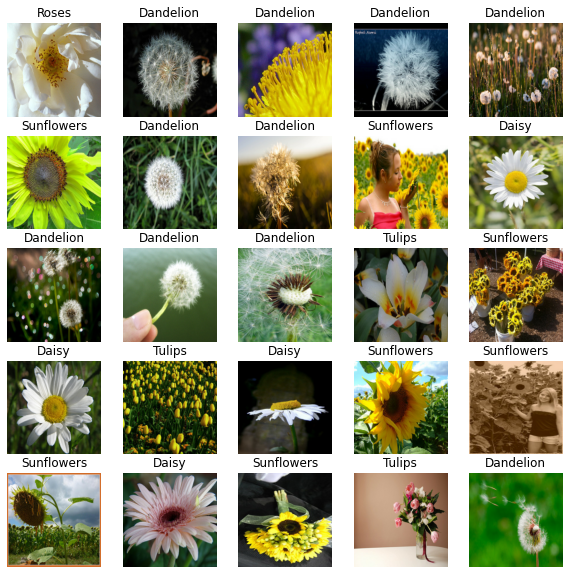

In [91]:
show_batch(image_batch.numpy(),label_batch.numpy())

Performance:
Para investigar, primeiro aqui está uma função para verificar o desempenho de nossos conjuntos de dados:


In [92]:
import time 
default_timeit_steps=1000

def timeit(ds, steps=default_timeit_steps):
  start=time.time()
  it=iter(ds)
  for i in range(steps):
    batch=next(it)
    if i%10==0:
      print(',', end=' ')
  print()
  end= time.time()

  duration=end-start
  print('{} batches: {} s'.format(steps, duration))
  print('{0:5f} Images/s'.format(BATCH_SIZE*steps/duration))

In [93]:
#Vamos comparar a velocidade dos dois geradores de dados:
timeit(train_data_gen)

, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 
1000 batches: 99.80462455749512 s
320.626425 Images/s


In [94]:
#tf.data
timeit(train_ds)

, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 
1000 batches: 13.07021689414978 s
2448.314382 Images/s


In [95]:
uncached_ds= prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 
1000 batches: 68.08375072479248 s
470.009358 Images/s


In [96]:
filecahce_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecahce_ds)

, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 
1000 batches: 31.999484539031982 s
1000.016108 Images/s
